# Training Set

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.externals import joblib
%matplotlib inline   

In [2]:
import os 
os.system('ps aux | grep wolfm2')
#os.system('killall -s SIGKILL -u wolfm2')
#os.system('cp /home/wolfm2/job.sh .; echo test 1>&2') #; cp ../job.log ../jerbb.txt')

isTraining = True

### Read raw training data

In [3]:
if isTraining:
    #amazon = pd.read_csv('/home/wolfm2/amazon_data.0/raw_data_train.csv')
    amazon = pd.read_csv('/home/wolfm2/amazon_data/raw_data_train.csv')
    #amazon = pd.read_csv('/home/ich/amazon_data/raw_data_train.csv')
else:
    amazon = pd.read_csv('/home/wolfm2/amazon_data.0/raw_data_test.csv')

print(amazon.shape)

(364000, 14)


In [4]:
print(amazon.head())
print(amazon['helpful'].mean())

   Unnamed: 0  Unnamed: 0.1      Id   ProductId          UserId  \
0      150581        487850  487851  B0025UCD76  A28B2M0XRXHXIG   
1      334018         21518   21519  B002QWP89S   A7JJX3KMDZD2F   
2       76657        319457  319458  B001GVIUX6  A2S8RJ6DRKGYON   
3      357903        248851  248852  B0009JRH1C  A1FLQ698D9C0C8   
4      301824        394613  394614  B001B4VOQI  A2KJO9EPX17ZXE   

                   ProfileName  HelpfulnessNumerator  HelpfulnessDenominator  \
0                         B622                     0                       0   
1  Shinichi Isozaki "shincyan"                     1                       2   
2                   M. Ronning                     1                       2   
3                     G. Zhang                     4                       8   
4                    Musical E                     0                       0   

   Score        Time                                            Summary  \
0      5  1313020800                     

### Feature extraction on natural language data

In [5]:
# # http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html
# from sklearn.feature_extraction.text import CountVectorizer
# vectorizer = CountVectorizer()
# corpus = amazon.Text.as_matrix()
# X_bag_of_words = vectorizer.fit_transform(corpus)
# print(X_bag_of_words.toarray())

In [6]:
import nltk
# nltk.download('punkt')
# nltk.download('popular')

from nltk import word_tokenize          
from nltk.stem import WordNetLemmatizer 

class LemmaTokenizer(object):
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, doc):
        return [self.wnl.lemmatize(t) for t in word_tokenize(doc)]

In [7]:
# vectorize Bag of Words from review text; as sparse matrix
from sklearn.feature_extraction.text import HashingVectorizer

# amazon['reviewLen'] = amazon['Text'].str.len() # Use this later /X as gross dummy

# amazon['textLower'] = amazon['Text'].str.lower()
# look at the text  token_pattern = r'\b[a-zA-Z0-9]{3,}\b',
if isTraining:
    hv0 = HashingVectorizer(n_features=2 ** 19, non_negative=True, tokenizer=LemmaTokenizer(), strip_accents=ascii,  stop_words={'english'}, token_pattern = r'\b[a-zA-Z]{3,}\b', ngram_range=(1,2))
    X_hv0 = hv0.fit_transform(amazon.Text)
    joblib.dump(hv0, 'hv0.pkl') # pickle
else:
    hv0 = joblib.load('hv0.pkl') # pickle
    X_hv0 = hv0.transform(amazon.Text)


# amazon['summaryFilter'] = amazon['Summary'].apply(lambda x: " " if x is np.nan else x) # some were np.nans
# amazon['sfLower'] = amazon['summaryFilter'].str.lower()
# # and a second domain where we look at the summary
# if isTraining:
#     hv1 = HashingVectorizer(n_features=2 ** 19, non_negative=True, tokenizer=LemmaTokenizer(), ngram_range=(1,3))
#     X_hv1 = hv1.fit_transform(amazon.sfLower) 
#     joblib.dump(hv1, 'hv1.pkl') # pickle
# else:
#     hv1 = joblib.load('hv1.pkl') # pickle
#     X_hv1 = hv1.transform(amazon.sfLower) 

# Another hash domain we want to count but not tfidf
# amazon['timeFilter'] = amazon['Time'].apply(lambda x: str(int(x)%(86400 * 7))) # converts to day of week
# hv2 = HashingVectorizer(n_features=2 ** 17, non_negative=True, strip_accents=ascii, 
#                            ngram_range=(1,1)) 
# X_hv2 = hv2.fit_transform(amazon.timeFilter + " " + amazon.ProductId + " " + amazon.UserId) # mw adds uid as token

# amazon['logReviewLen'] = np.round(np.log(amazon['Text'].str.len()),decimals=1) + 10
# amazon.hist(column="logReviewLen")

amazon['ScoreX'] = amazon['Score'].apply(lambda x: str(x)) # make score acceptable
# amazon['sLogReviewLen'] = amazon['logReviewLen'].apply(lambda x: str(x)) # make score acceptable
if isTraining:
    hv2 = HashingVectorizer(n_features=2 ** 17, non_negative=True, ngram_range=(1,1)) 
    X_hv2 = hv2.fit_transform(amazon.ScoreX) # mw adds uid as token
    joblib.dump(hv2, 'hv2.pkl') # pickle
else:
    hv2 = joblib.load('hv2.pkl') # pickle
    X_hv2 = hv2.transform(amazon.ScoreX) # mw adds uid as token

import scipy.sparse as sp
# X_hv = sp.hstack([X_hv0], format='csr')
X_hv = X_hv0
print(X_hv.shape)

print(amazon.head())

/home/wolfm2/anaconda3/lib/python3.6/site-packages/sklearn/feature_extraction/hashing.py:94: DeprecationWarning: the option non_negative=True has been deprecated in 0.19 and will be removed in version 0.21.
  " in version 0.21.", DeprecationWarning)
/home/wolfm2/anaconda3/lib/python3.6/site-packages/sklearn/feature_extraction/hashing.py:94: DeprecationWarning: the option non_negative=True has been deprecated in 0.19 and will be removed in version 0.21.
  " in version 0.21.", DeprecationWarning)


/home/wolfm2/anaconda3/lib/python3.6/site-packages/sklearn/feature_extraction/hashing.py:94: DeprecationWarning: the option non_negative=True has been deprecated in 0.19 and will be removed in version 0.21.
  " in version 0.21.", DeprecationWarning)
/home/wolfm2/anaconda3/lib/python3.6/site-packages/sklearn/feature_extraction/hashing.py:94: DeprecationWarning: the option non_negative=True has been deprecated in 0.19 and will be removed in version 0.21.
  " in version 0.21.", DeprecationWarning)


(364000, 524288)
   Unnamed: 0  Unnamed: 0.1      Id   ProductId          UserId  \
0      150581        487850  487851  B0025UCD76  A28B2M0XRXHXIG   
1      334018         21518   21519  B002QWP89S   A7JJX3KMDZD2F   
2       76657        319457  319458  B001GVIUX6  A2S8RJ6DRKGYON   
3      357903        248851  248852  B0009JRH1C  A1FLQ698D9C0C8   
4      301824        394613  394614  B001B4VOQI  A2KJO9EPX17ZXE   

                   ProfileName  HelpfulnessNumerator  HelpfulnessDenominator  \
0                         B622                     0                       0   
1  Shinichi Isozaki "shincyan"                     1                       2   
2                   M. Ronning                     1                       2   
3                     G. Zhang                     4                       8   
4                    Musical E                     0                       0   

   Score        Time                                            Summary  \
0      5  1313020800    

In [8]:
# x = amazon.UserId + " " +  amazon.Text
# x.head(10)

In [9]:
# We want to be able to use this model fit on other data (the test set)
# So let's save a copy of this instance of HashingVectorizer to be able to transform other data with this fit
# http://scikit-learn.org/stable/modules/model_persistence.html
# if isTraining:
#     joblib.dump(hv0, 'hv0.pkl') # pickle
#     joblib.dump(hv1, 'hv1.pkl') # pickle
#     joblib.dump(hv2, 'hv2.pkl') # pickle

In [10]:
# http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html
from sklearn.feature_extraction.text import TfidfTransformer
if isTraining:
    transformer = TfidfTransformer()
    X_tfidf = transformer.fit_transform(X_hv, X_hv2)
    joblib.dump(transformer, 'transformer.pkl') # pickle
else:
    transformer = joblib.load('transformer.pkl') # pickle
    X_tfidf = transformer.transform(X_hv)
    

In [11]:
print(type(X_tfidf))

<class 'scipy.sparse.csr.csr_matrix'>


### Create additional quantitative features

In [12]:
# features from Amazon.csv to add to feature set
import re

#amazon['reviewLen'] = amazon['Text'].str.len()
#amazon['summaryLen'] = amazon['summaryFilter'].str.len()

#amazon['rlMeanDist'] = amazon['reviewLen'].apply(lambda x: abs(x-80)) # 80 is avg summary len. Thx George!
#amazon['slMeanDist'] = amazon['summaryLen'].apply(lambda x: abs(x-8)) # 8. just guessing here.

#import zlib
#amazon['nameHash'] = zlib.crc32(str(amazon['UserId']).encode('utf8'))
#amazon['nameHash'] = amazon['UserId'].apply(lambda x: zlib.crc32(str(x).encode('utf8'))) # bad. don't do it this way

# stackoverflow.com/questions/15772371/finding-average-length-of-items-in-a-list-python
# averages array element lengths
def avgLen(text, regex):
    lst = re.findall(regex, text)
    lengths = [len(i) for i in lst]
    return 0 if len(lengths) == 0 else (float(sum(lengths)) / len(lengths)) 

# ratio of regex to whole
def cRatio(text, regex):
    num = len(re.findall(regex, text))
    text = "" if text is np.nan else text
    den = len(text)
    return 0 if den == 0 else num / den

# some were np.nans
amazon['summaryFilter'] = amazon['Summary'].apply(lambda x: " " if x is np.nan else x) 

# Summary Len
amazon['summaryLen'] = amazon['summaryFilter'].str.len()

# Review Len
amazon['textLen'] = amazon['Text'].str.len()

# Num Words
amazon['numWords'] = amazon['Text'].apply(lambda x: len(re.findall("[a-zA-Z']+", x)))

# Num Cap Words
amazon['numCapWords'] = amazon['Text'].apply(lambda x: len(re.findall("[A-Z']+", x)))

# Avg Sentence Len
amazon['avgSenLen'] = amazon['Text'].apply(lambda x: avgLen(x, "[a-zA-Z' ]+"))

# Avg Word Len
amazon['avgWrdLen'] = amazon['Text'].apply(lambda x: avgLen(x, "[a-zA-Z']+"))

# ! Ratio
# amazon['ratioBang'] = amazon['Text'].apply(lambda x: cRatio(x, "\!"))

# ? Ratio                             
# amazon['ratioQmark'] = amazon['Text'].apply(lambda x: cRatio(x, "\?"))

print(amazon.head())

# X_quant_features = amazon[["Score", "reviewLen", "summaryLen", "rlMeanDist", "slMeanDist"]]
# print(X_quant_features.head(10))
# print(type(X_quant_features))
X_quant_features = amazon[['summaryLen', 'textLen', 'numWords', 'numCapWords', 'avgSenLen', 'avgWrdLen', 'Score']]
# X_quant_features = amazon[[]]

   Unnamed: 0  Unnamed: 0.1      Id   ProductId          UserId  \
0      150581        487850  487851  B0025UCD76  A28B2M0XRXHXIG   
1      334018         21518   21519  B002QWP89S   A7JJX3KMDZD2F   
2       76657        319457  319458  B001GVIUX6  A2S8RJ6DRKGYON   
3      357903        248851  248852  B0009JRH1C  A1FLQ698D9C0C8   
4      301824        394613  394614  B001B4VOQI  A2KJO9EPX17ZXE   

                   ProfileName  HelpfulnessNumerator  HelpfulnessDenominator  \
0                         B622                     0                       0   
1  Shinichi Isozaki "shincyan"                     1                       2   
2                   M. Ronning                     1                       2   
3                     G. Zhang                     4                       8   
4                    Musical E                     0                       0   

   Score        Time    ...     helpScore helpful  ScoreX  \
0      5  1313020800    ...           NaN   False      

### Combine all quantitative features into a single sparse matrix

In [13]:
from scipy.sparse import csr_matrix, hstack
X_quant_features_csr = csr_matrix(X_quant_features)
X_combined = hstack([X_tfidf, X_quant_features_csr])  # we dont want to penalize hv2 w tfidf MW
X_matrix = csr_matrix(X_combined) # convert to sparse matrix
print(X_matrix.shape)

(364000, 524295)


### Create `X`, scaled matrix of features

In [14]:
# feature scaling
from sklearn.preprocessing import StandardScaler
if isTraining:
    sc = StandardScaler(with_mean=False)
    X = sc.fit_transform(X_matrix)
    joblib.dump(sc, 'sc.pkl') # pickle
else:
    sc = joblib.load('sc.pkl')
    X = sc.transform(X_matrix)

print(X.shape)

(364000, 524295)


### create `y`, vector of Labels

In [15]:
y = amazon['helpful'].values
print(type(y))

<class 'numpy.ndarray'>


### fit models

In [16]:
from my_measures import BinaryClassificationPerformance

In [17]:
from sklearn.linear_model import LogisticRegression

if isTraining:
    m0 = LogisticRegression()
    m0.fit(X, y)
    joblib.dump(m0, 'log.pkl')
else:
    m0 = joblib.load('log.pkl')
    m0_performance = BinaryClassificationPerformance(m0.predict(X), y, 'log')
    m0_performance.compute_measures()
    print(m0_performance.performance_measures)

In [18]:
from sklearn import tree

if isTraining:
    m0 = tree.DecisionTreeClassifier(criterion='gini')
    m0.fit(X, y)
    joblib.dump(m0, 'tree.pkl')
else:
    m0 = joblib.load('tree.pkl')
    m1_performance = BinaryClassificationPerformance(m0.predict(X), y, 'tree')
    m1_performance.compute_measures()
    print(m1_performance.performance_measures)

In [19]:
'''
from sklearn import svm

if isTraining:
    m0 = svm.svc()
    m0.fit(X, y)
    joblib.dump(m0, 'svm.pkl')
else:
    m0 = joblib.load('svm.pkl')
    m2_performance = BinaryClassificationPerformance(m0.predict(X), y, 'svm')
    m2_performance.compute_measures()
    print(m2_performance.performance_measures)
'''

"\nfrom sklearn import svm\n\nif isTraining:\n    m0 = svm.svc()\n    m0.fit(X, y)\n    joblib.dump(m0, 'svm.pkl')\nelse:\n    m0 = joblib.load('svm.pkl')\n    m2_performance = BinaryClassificationPerformance(m0.predict(X), y, 'svm')\n    m2_performance.compute_measures()\n    print(m2_performance.performance_measures)\n"

In [20]:
'''from sklearn.naive_bayes import GaussianNB

if isTraining:
    m0 = GaussianNB()
    m0.fit(X, y)
    joblib.dump(m0, 'nb.pkl')
else:
    m0 = joblib.load('nb.pkl')
    m3_performance = BinaryClassificationPerformance(m0.predict(X), y, 'nb')
    m3_performance.compute_measures()
    print(m3_performance.performance_measures)'''

"from sklearn.naive_bayes import GaussianNB\n\nif isTraining:\n    m0 = GaussianNB()\n    m0.fit(X, y)\n    joblib.dump(m0, 'nb.pkl')\nelse:\n    m0 = joblib.load('nb.pkl')\n    m3_performance = BinaryClassificationPerformance(m0.predict(X), y, 'nb')\n    m3_performance.compute_measures()\n    print(m3_performance.performance_measures)"

In [21]:
'''from sklearn.neighbors import KNeighborsClassifier

if isTraining:
    m0 = KNeighborsClassifier(n_neighbors=6)
    m0.fit(X, y)
    joblib.dump(m0, 'kn.pkl')
else:
    m0 = joblib.load('kn.pkl')
    m4_performance = BinaryClassificationPerformance(m0.predict(X), y, 'kn')
    m4_performance.compute_measures()
    print(m4_performance.performance_measures)'''

"from sklearn.neighbors import KNeighborsClassifier\n\nif isTraining:\n    m0 = KNeighborsClassifier(n_neighbors=6)\n    m0.fit(X, y)\n    joblib.dump(m0, 'kn.pkl')\nelse:\n    m0 = joblib.load('kn.pkl')\n    m4_performance = BinaryClassificationPerformance(m0.predict(X), y, 'kn')\n    m4_performance.compute_measures()\n    print(m4_performance.performance_measures)"

In [22]:
from sklearn.ensemble import RandomForestClassifier

if isTraining:
    m0 = RandomForestClassifier(n_estimators=50, max_features='log2')
    m0.fit(X, y)
    joblib.dump(m0, 'rf.pkl')
else:
    m0 = joblib.load('rf.pkl')
    m5_performance = BinaryClassificationPerformance(m0.predict(X), y, 'rf')
    m5_performance.compute_measures()
    print(m5_performance.performance_measures)

In [23]:
from sklearn.ensemble import GradientBoostingClassifier

if isTraining:
    m0 = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0)
    m0.fit(X, y)
    joblib.dump(m0, 'gb.pkl')
else:
    m0 = joblib.load('gb.pkl')
    m6_performance = BinaryClassificationPerformance(m0.predict(X), y, 'gb')
    m6_performance.compute_measures()
    print(m6_performance.performance_measures)

In [24]:
'''from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

if isTraining:
    m0 = XGBClassifier()
    m0.fit(X, y)
    joblib.dump(m0, 'xgb.pkl')
else:
    m0 = joblib.load('xgb.pkl')
    m7_performance = BinaryClassificationPerformance(m0.predict(X), y, 'xgb')
    m7_performance.compute_measures()
    print(m7_performance.performance_measures)'''

"from xgboost import XGBClassifier\nfrom sklearn.model_selection import train_test_split\nfrom sklearn.metrics import accuracy_score\n\nif isTraining:\n    m0 = XGBClassifier()\n    m0.fit(X, y)\n    joblib.dump(m0, 'xgb.pkl')\nelse:\n    m0 = joblib.load('xgb.pkl')\n    m7_performance = BinaryClassificationPerformance(m0.predict(X), y, 'xgb')\n    m7_performance.compute_measures()\n    print(m7_performance.performance_measures)"

In [25]:
'''from catboost import CatBoostRegressor

if isTraining:
    m0 = CatBoostRegressor(iterations=50, depth=3, learning_rate=0.1, loss_function='RMSE')
    m0.fit(X, y)
    joblib.dump(m0, 'cb.pkl')
else:
    m0 = joblib.load('cb.pkl')
    m8_performance = BinaryClassificationPerformance(m0.predict(X), y, 'cb')
    m8_performance.compute_measures()
    print(m8_performance.performance_measures)'''

"from catboost import CatBoostRegressor\n\nif isTraining:\n    m0 = CatBoostRegressor(iterations=50, depth=3, learning_rate=0.1, loss_function='RMSE')\n    m0.fit(X, y)\n    joblib.dump(m0, 'cb.pkl')\nelse:\n    m0 = joblib.load('cb.pkl')\n    m8_performance = BinaryClassificationPerformance(m0.predict(X), y, 'cb')\n    m8_performance.compute_measures()\n    print(m8_performance.performance_measures)"

In [26]:
# # MODEL: SVM, linear
# from sklearn import linear_model
# svm = linear_model.SGDClassifier()
# svm.fit(X, y)

# joblib.dump(svm, 'svm.pkl') # pickle

if not isTraining:
    svm = joblib.load('best.svm.pkl')
    svm_performance = BinaryClassificationPerformance(svm.predict(X), y, 'svm')
    svm_performance.compute_measures()
    print(svm_performance.performance_measures)

In [27]:
# # MODEL: logistic regression
# from sklearn import linear_model
# #lgs = linear_model.SGDClassifier(loss='log', n_iter=50, alpha=0.00001)
# lgs = linear_model.SGDClassifier(loss='log', n_iter=1000, alpha=0.1)

# lgs.fit(X, y)
# joblib.dump(lgs, 'lgs.pkl') # pickle
if not isTraining:
    lgs = joblib.load('best.lgs.pkl')
    lgs_performance = BinaryClassificationPerformance(lgs.predict(X), y, 'lgs')
    lgs_performance.compute_measures()
    print(lgs_performance.performance_measures)

In [28]:
# # MODEL: Naive Bayes
# from sklearn.naive_bayes import MultinomialNB
# nbs = MultinomialNB()
# nbs.fit(X, y)
# joblib.dump(nbs, 'nbs.pkl') # pickle
if not isTraining:
    nbs = joblib.load('best.nbs.pkl')
    nbs_performance = BinaryClassificationPerformance(nbs.predict(X), y, 'nbs')
    nbs_performance.compute_measures()
    print(nbs_performance.performance_measures)

In [29]:
# # MODEL: Ridge Regression Classifier
# from sklearn import linear_model
# rdg = linear_model.RidgeClassifier()
# rdg.fit(X, y)
# joblib.dump(rdg, 'rdg.pkl') # pickle
if not isTraining:
    rdg = joblib.load('best.rdg.pkl')
    rdg_performance = BinaryClassificationPerformance(rdg.predict(X), y, 'rdg')
    rdg_performance.compute_measures()
    print(rdg_performance.performance_measures)

In [30]:
# # MODEL: Perceptron
# from sklearn import linear_model
# prc = linear_model.SGDClassifier(loss='perceptron')
# prc.fit(X, y)
# joblib.dump(prc, 'prc.pkl') # pickle
if not isTraining:
    prc = joblib.load('best.prc.pkl')
    prc_performance = BinaryClassificationPerformance(prc.predict(X), y, 'prc')
    prc_performance.compute_measures()
    print(prc_performance.performance_measures)

In [31]:
import json
import datetime
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn import linear_model
from sklearn.naive_bayes import MultinomialNB

from sklearn.neural_network import MLPClassifier # mw

# prepare a range of alpha values to test
# alphas = np.array([1,0.1,0.01,0.001,0.0001,0])
alphas = np.array([1, 0.1, 0.01, 0.001, 0.0001, 0.00001])
Cs = np.array([0.001, 0.01, 0.1, 1, 10, 100, 1000])
# create and fit a ridge regression model, testing each alpha
# model = linear_model.SGDClassifier(loss='perceptron', max_iter=50) # max_iter 1000

if isTraining:
    mlp = MLPClassifier(random_state=0)
    svm = linear_model.SGDClassifier(n_iter=500)
    lgs = linear_model.SGDClassifier(loss='log', n_iter=500)
    nbs = MultinomialNB()
    rdg = linear_model.RidgeClassifier()
    prc = linear_model.SGDClassifier(loss='perceptron', n_iter=500)
    mList = [[svm,"svm"], [lgs,"lgs"], [prc,"prc"], [nbs,"nbs"], [rdg,"rdg"]] # 
    
else:
    mList = []

for model in mList: 
# for model in []: 
# for model in [rdg]:    
  fh = open("GridSearch.txt", "a")
  grid = GridSearchCV(estimator=model[0], param_grid=dict(alpha=alphas), n_jobs=2) #
  grid.fit(X, y)
  print(grid)
  # summarize the results of the grid search
  print(grid.cv_results_)
  print(grid.best_score_)
  print(grid.best_estimator_.alpha)

  fh.write('\n########\n')
  fh.write(str(datetime.datetime.now()))
  fh.write('\n########\n')
  fh.write(str(model[0]) + '\n')  
  fh.write(str(grid.cv_results_).replace(", '", ",\n'") + '\n')
  fh.write(str(grid.best_score_) + '\n')  
  fh.write(str(grid.best_estimator_.alpha) + '\n')
  fh.close()

  # MODEL: BEST
  best = grid.best_estimator_

  best.fit(X, y)
  joblib.dump(best, 'best.{}.pkl'.format(model[1])) # pickle

  best_performance = BinaryClassificationPerformance(best.predict(X), y, 'best')
  best_performance.compute_measures()
  print(best_performance.performance_measures)
  

/home/wolfm2/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


/home/wolfm2/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


/home/wolfm2/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


/home/wolfm2/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


/home/wolfm2/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


/home/wolfm2/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


/home/wolfm2/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


/home/wolfm2/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


/home/wolfm2/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


/home/wolfm2/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


/home/wolfm2/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


/home/wolfm2/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


/home/wolfm2/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


/home/wolfm2/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


/home/wolfm2/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


/home/wolfm2/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


/home/wolfm2/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


/home/wolfm2/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


/home/wolfm2/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


GridSearchCV(cv=None, error_score='raise',
       estimator=SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=500,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=2,
       param_grid={'alpha': array([  1.00000e+00,   1.00000e-01,   1.00000e-02,   1.00000e-03,
         1.00000e-04,   1.00000e-05])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)
{'mean_fit_time': array([ 78.0295461 ,  75.92828528,  75.35010338,  75.95095984,
        75.33556167,  74.51533262]), 'std_fit_time': array([ 1.00474017,  0.83959293,  0.89983625,  0.95811728,  0.94093143,
        1.73438339]), 'mean_score_time': array([ 0.0557367 ,  0.05425501,  0.05450686,  0.05546641,  0.05458593,
        0.05096

/home/wolfm2/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


{'Pos': 26647, 'Neg': 337353, 'TP': 20447, 'TN': 337315, 'FP': 38, 'FN': 6200, 'Accuracy': 0.98286263736263735, 'Precision': 0.99814498413473274, 'Recall': 0.76732840469846508, 'desc': 'best'}


/home/wolfm2/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


/home/wolfm2/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


/home/wolfm2/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


/home/wolfm2/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


/home/wolfm2/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


/home/wolfm2/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


/home/wolfm2/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


/home/wolfm2/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


/home/wolfm2/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


/home/wolfm2/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


/home/wolfm2/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


/home/wolfm2/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


/home/wolfm2/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


/home/wolfm2/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


/home/wolfm2/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


/home/wolfm2/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


/home/wolfm2/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


/home/wolfm2/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


/home/wolfm2/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


GridSearchCV(cv=None, error_score='raise',
       estimator=SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='log', max_iter=None, n_iter=500,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=2,
       param_grid={'alpha': array([  1.00000e+00,   1.00000e-01,   1.00000e-02,   1.00000e-03,
         1.00000e-04,   1.00000e-05])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)
{'mean_fit_time': array([ 102.77531656,  102.39061252,  101.46347586,  101.21796695,
         98.2765762 ,  100.30487665]), 'std_fit_time': array([ 0.88081378,  0.80961124,  0.73494287,  1.65600876,  1.38728072,
        2.83594916]), 'mean_score_time': array([ 0.05556051,  0.05139748,  0.05159473,  0.05117846,  0.05100354,
        0.0

/home/wolfm2/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


{'Pos': 26647, 'Neg': 337353, 'TP': 24285, 'TN': 337321, 'FP': 32, 'FN': 2362, 'Accuracy': 0.99342307692307696, 'Precision': 0.99868404819673484, 'Recall': 0.91135962772544754, 'desc': 'best'}


/home/wolfm2/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


/home/wolfm2/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


/home/wolfm2/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


/home/wolfm2/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


/home/wolfm2/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


/home/wolfm2/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


/home/wolfm2/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


/home/wolfm2/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


/home/wolfm2/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


/home/wolfm2/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


/home/wolfm2/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


/home/wolfm2/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


/home/wolfm2/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


/home/wolfm2/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


/home/wolfm2/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


/home/wolfm2/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


/home/wolfm2/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


/home/wolfm2/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


/home/wolfm2/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


GridSearchCV(cv=None, error_score='raise',
       estimator=SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='perceptron', max_iter=None,
       n_iter=500, n_jobs=1, penalty='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=2,
       param_grid={'alpha': array([  1.00000e+00,   1.00000e-01,   1.00000e-02,   1.00000e-03,
         1.00000e-04,   1.00000e-05])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)
{'mean_fit_time': array([ 73.50615072,  73.44305023,  72.72910762,  73.20319557,
        72.6281263 ,  71.01314076]), 'std_fit_time': array([ 1.6564261 ,  1.11718233,  1.20998222,  0.91436328,  1.09536517,
        3.07199065]), 'mean_score_time': array([ 0.05162938,  0.05757515,  0.05248149,  0.05316941,  0.0526197 ,
        0.

/home/wolfm2/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


{'Pos': 26647, 'Neg': 337353, 'TP': 26494, 'TN': 337216, 'FP': 137, 'FN': 153, 'Accuracy': 0.99920329670329666, 'Precision': 0.99485561939093536, 'Recall': 0.99425826547078466, 'desc': 'best'}


GridSearchCV(cv=None, error_score='raise',
       estimator=MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True),
       fit_params=None, iid=True, n_jobs=2,
       param_grid={'alpha': array([  1.00000e+00,   1.00000e-01,   1.00000e-02,   1.00000e-03,
         1.00000e-04,   1.00000e-05])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)
{'mean_fit_time': array([ 1.19678934,  1.04240513,  1.07987809,  1.06308921,  1.07577618,
        1.03226296]), 'std_fit_time': array([ 0.06359307,  0.02582281,  0.07617313,  0.05186386,  0.07362185,
        0.09467519]), 'mean_score_time': array([ 0.13021986,  0.12735915,  0.137151  ,  0.12666941,  0.13832895,
        0.11850174]), 'std_score_time': array([ 0.00062035,  0.00257504,  0.01442114,  0.00316936,  0.01307779,
        0.03104733]), 'param_alpha': masked_array(data = [1.0 0.10000000000000001 0.01 0.001 0.0001 1.0000000000000001e-05],
             mask = [False False False False Fal

{'Pos': 26647, 'Neg': 337353, 'TP': 25948, 'TN': 329069, 'FP': 8284, 'FN': 699, 'Accuracy': 0.97532142857142856, 'Precision': 0.75800420659032486, 'Recall': 0.97376815401358507, 'desc': 'best'}


GridSearchCV(cv=None, error_score='raise',
       estimator=RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
        max_iter=None, normalize=False, random_state=None, solver='auto',
        tol=0.001),
       fit_params=None, iid=True, n_jobs=2,
       param_grid={'alpha': array([  1.00000e+00,   1.00000e-01,   1.00000e-02,   1.00000e-03,
         1.00000e-04,   1.00000e-05])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)
{'mean_fit_time': array([ 494.94733135,  502.34453646,  505.22551703,  496.63837123,
        497.70648654,  491.9726758 ]), 'std_fit_time': array([  89.84046111,   78.56337947,   93.6781102 ,  101.91263327,
         89.58700474,   72.81753125]), 'mean_score_time': array([ 0.04976288,  0.04977274,  0.04968445,  0.05066705,  0.04978053,
        0.04797403]), 'std_score_time': array([ 0.0018305 ,  0.00109061,  0.00135337,  0.00128541,  0.00142646,
        0.00351477]), 'param_alpha':

{'Pos': 26647, 'Neg': 337353, 'TP': 26449, 'TN': 337276, 'FP': 77, 'FN': 198, 'Accuracy': 0.9992445054945055, 'Precision': 0.99709718766493249, 'Recall': 0.99256952002101551, 'desc': 'best'}


In [32]:
'''
pg = {'learning_rate': ["constant", "invscaling", "adaptive"],
'hidden_layer_sizes': [(100,1), (100,2), (100,3)],
#'alpha': [10.0 ** -np.arange(1, 7)],
'alpha': [1, 0.1, 0.01, 0.001, 0.0001, 0.00001],
'activation': ["logistic", "relu", "Tanh"],
'tol': [1e-2, 1e-4, 1e-6],
'epsilon': [1e-3, 1e-7, 1e-8, 1e-9, 1e-8]
}

fh = open("GridSearch.txt", "a")
grid = GridSearchCV(estimator=mlp, param_grid=pg, n_jobs=2) #
grid.fit(X, y)
print(grid)
# summarize the results of the grid search
print(grid.cv_results_)
print(grid.best_score_)
print(grid.best_estimator_.alpha)

fh.write('\n########\n')
fh.write(str(datetime.datetime.now()))
fh.write('\n########\n')
fh.write(str(model) + '\n')  
fh.write(str(grid.cv_results_).replace(", '", ",\n'") + '\n')
fh.write(str(grid.best_score_) + '\n')  
fh.write(str(grid.best_estimator_.alpha) + '\n')
fh.close()
'''

'\npg = {\'learning_rate\': ["constant", "invscaling", "adaptive"],\n\'hidden_layer_sizes\': [(100,1), (100,2), (100,3)],\n#\'alpha\': [10.0 ** -np.arange(1, 7)],\n\'alpha\': [1, 0.1, 0.01, 0.001, 0.0001, 0.00001],\n\'activation\': ["logistic", "relu", "Tanh"],\n\'tol\': [1e-2, 1e-4, 1e-6],\n\'epsilon\': [1e-3, 1e-7, 1e-8, 1e-9, 1e-8]\n}\n\nfh = open("GridSearch.txt", "a")\ngrid = GridSearchCV(estimator=mlp, param_grid=pg, n_jobs=2) #\ngrid.fit(X, y)\nprint(grid)\n# summarize the results of the grid search\nprint(grid.cv_results_)\nprint(grid.best_score_)\nprint(grid.best_estimator_.alpha)\n\nfh.write(\'\n########\n\')\nfh.write(str(datetime.datetime.now()))\nfh.write(\'\n########\n\')\nfh.write(str(model) + \'\n\')  \nfh.write(str(grid.cv_results_).replace(", \'", ",\n\'") + \'\n\')\nfh.write(str(grid.best_score_) + \'\n\')  \nfh.write(str(grid.best_estimator_.alpha) + \'\n\')\nfh.close()\n'

### ROC plot to compare performance of various models and fits

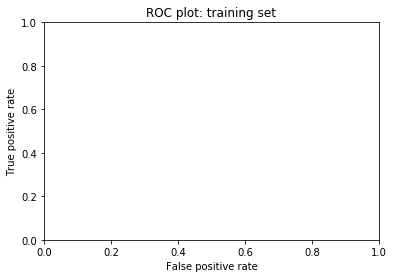

In [33]:
if isTraining:
    fList = []
else:
    fits = [svm_performance, lgs_performance, nbs_performance, rdg_performance, prc_performance, m0_performance, m1_performance, m5_performance, m6_performance]
    fList = fits

for fit in fList:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'ro')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0, 1])
if isTraining:
    plt.title('ROC plot: training set')
else:
    plt.title('ROC plot: testing set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()